In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210712'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 10.66it/s]


(642837, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([yunrip_df]).sort_values(['지번주소', '건축년도', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(642837, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,57.67,52000,5,2015.0,0.0,2015-05-15,901.681984,6.0,연립다세대
4,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,72.44,56000,5,2015.0,0.0,2015-06-17,773.053562,6.0,연립다세대


In [9]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [78]:
bulktrade_basedir = './국토교통부_실거래가_공개시스템/집값분석/일괄구매/10호이상/'
bulktrade_df = pd.read_csv(bulktrade_basedir + '2018년01월01일부터_2021년06월07일까지_SH_LH_아파트_연립다세대_오피스텔_거래사례.csv')
bulktrade_df = bulktrade_df.drop(columns=['Unnamed: 0'])
#bulktrade_df['지번주소'] = '서울특별시 ' + bulktrade_df['지번주소']
print(bulktrade_df.shape)
bulktrade_df.head()

(14793, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,소유자
0,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.39,28300,3,2020.0,0.0,2020-03-02,1114.612052,1.0,연립다세대,SH
1,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.39,28300,2,2020.0,0.0,2020-03-02,1114.612052,1.0,연립다세대,SH
2,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.46,28400,3,2020.0,0.0,2020-03-02,1115.475255,1.0,연립다세대,SH
3,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.46,28400,2,2020.0,0.0,2020-03-02,1115.475255,1.0,연립다세대,SH
4,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.55,28500,3,2020.0,0.0,2020-03-02,1115.459883,1.0,연립다세대,SH


In [79]:
bulktrade_df['소유자'].value_counts()

SH    8474
LH    6319
Name: 소유자, dtype: int64

In [83]:
bulktrade_df2 = pd.read_csv(bulktrade_basedir + '2018부터_아파트_연립다세대_오피스텔_일괄구매_전체_소유자_포함_기존자료_제외.csv')
#bulktrade_df = bulktrade_df.drop(columns=['Unnamed: 0'])
#bulktrade_df['지번주소'] = '서울특별시 ' + bulktrade_df['지번주소']
bulktrade_df2 = bulktrade_df2.dropna(subset=['소유자'])
bulktrade_df2['소유자'] = bulktrade_df2['소유자'].apply(lambda x: x.replace('서***~', 'SH'))
bulktrade_df2['소유자'] = bulktrade_df2['소유자'].apply(lambda x: x.replace('한***~', 'LH'))
print(bulktrade_df2.shape)
bulktrade_df2.head()

(10718, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,소유자
0,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,21.50,25850,4,2021.0,0.0,2021-06-22,1202.325581,0.0,연립다세대,장**외 1명
1,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,21.92,25950,3,2021.0,0.0,2021-06-22,1183.850365,0.0,연립다세대,장**외 1명
2,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,21.92,26050,2,2021.0,0.0,2021-06-22,1188.412409,0.0,연립다세대,장**외 1명
3,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,24.42,28150,5,2021.0,0.0,2021-06-22,1152.743653,0.0,연립다세대,장**외 1명
4,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,25.01,29450,3,2021.0,0.0,2021-06-22,1177.528988,0.0,연립다세대,장**외 1명


In [84]:
bulktrade_df = pd.concat([bulktrade_df, bulktrade_df2]).reset_index(drop=True)
bulktrade_df = bulktrade_df[
    (bulktrade_df['소유자'] == 'SH')
    |(bulktrade_df['소유자'] == 'LH')
]
print(bulktrade_df.shape)
bulktrade_df.head()

(15782, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,소유자
0,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.39,28300,3,2020.0,0.0,2020-03-02,1114.612052,1.0,연립다세대,SH
1,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.39,28300,2,2020.0,0.0,2020-03-02,1114.612052,1.0,연립다세대,SH
2,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.46,28400,3,2020.0,0.0,2020-03-02,1115.475255,1.0,연립다세대,SH
3,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.46,28400,2,2020.0,0.0,2020-03-02,1115.475255,1.0,연립다세대,SH
4,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.55,28500,3,2020.0,0.0,2020-03-02,1115.459883,1.0,연립다세대,SH


In [85]:
bulktrade_df['소유자'].value_counts()

SH    8970
LH    6812
Name: 소유자, dtype: int64

In [86]:
bulktrade_df['계약날짜'] = pd.to_datetime(bulktrade_df['계약날짜'])

In [87]:
bulktrade_df['구'] = bulktrade_df['지번주소'].apply(lambda x: x.split(' ')[1])
bulktrade_df['동'] = bulktrade_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [88]:
bulktrade_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,소유자,구,동
0,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.39,28300,3,2020.0,0.0,2020-03-02,1114.612052,1.0,연립다세대,SH,강남구,개포동
1,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.39,28300,2,2020.0,0.0,2020-03-02,1114.612052,1.0,연립다세대,SH,강남구,개포동
2,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.46,28400,3,2020.0,0.0,2020-03-02,1115.475255,1.0,연립다세대,SH,강남구,개포동
3,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.46,28400,2,2020.0,0.0,2020-03-02,1115.475255,1.0,연립다세대,SH,강남구,개포동
4,서울특별시 강남구 개포동 1195-10,논현로12길 3-1,동영빌,25.55,28500,3,2020.0,0.0,2020-03-02,1115.459883,1.0,연립다세대,SH,강남구,개포동


In [99]:
target_df = house_df[
    (house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['계약날짜'] < (date_today - pd.DateOffset(months=1)))
    &(house_df['건물연식'] <= 2)
    &(house_df['전용면적(㎡)'] <= 32)
    &(house_df['전용면적(㎡)'] >= 28)
    &(house_df['지번주소'].isin(bulktrade_df['지번주소'].unique()) == False)
]
print(target_df.shape)
target_df.head()

(1945, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
63,서울특별시 강남구 개포동 1166-5,논현로2길 45,스타빌,29.88,33000,4,2020.0,1.0,2021-04-26,1104.417671,1.0,연립다세대,강남구,개포동
64,서울특별시 강남구 개포동 1166-5,논현로2길 45,스타빌,29.88,36000,4,2020.0,1.0,2021-06-04,1204.819277,1.0,연립다세대,강남구,개포동
3714,서울특별시 강남구 논현동 158-15,강남대로122길 61-1,NONHYEON VARAUM,29.97,85700,5,2020.0,1.0,2021-05-03,2859.526193,1.0,연립다세대,강남구,논현동
3718,서울특별시 강남구 논현동 158-15,강남대로122길 61-1,NONHYEON VARAUM,29.79,83700,5,2020.0,1.0,2021-06-02,2809.667674,1.0,연립다세대,강남구,논현동
3786,서울특별시 강남구 논현동 160-4,강남대로122길 29-6,논현퍼스티움,28.22,46300,3,2020.0,0.0,2020-08-31,1640.680369,1.0,연립다세대,강남구,논현동


In [100]:
bulktrade_target_df = bulktrade_df[
    (bulktrade_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(bulktrade_df['계약날짜'] < (date_today - pd.DateOffset(months=1)))
    &(bulktrade_df['건물연식'] <= 2)
    &(bulktrade_df['전용면적(㎡)'] <= 32)
    &(bulktrade_df['전용면적(㎡)'] >= 28)
    #&(house_df['지번주소'].isin(bulktrade_df['지번주소'].unique()) == False)
]
print(bulktrade_target_df.shape)
bulktrade_target_df.head()

(1314, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,소유자,구,동
44,서울특별시 강남구 개포동 1237-7,논현로20길 20,한별2,29.08,32909,2,2021.0,0.0,2021-06-01,1131.671252,0.0,오피스텔,SH,강남구,개포동
45,서울특별시 강남구 개포동 1237-7,논현로20길 20,한별2,29.86,33784,2,2021.0,0.0,2021-06-01,1131.413262,0.0,오피스텔,SH,강남구,개포동
46,서울특별시 강남구 개포동 1237-7,논현로20길 20,한별2,29.86,33784,2,2021.0,0.0,2021-06-01,1131.413262,0.0,오피스텔,SH,강남구,개포동
47,서울특별시 강남구 개포동 1237-7,논현로20길 20,한별2,29.86,33784,2,2021.0,0.0,2021-06-01,1131.413262,0.0,오피스텔,SH,강남구,개포동
48,서울특별시 강남구 개포동 1237-7,논현로20길 20,한별2,29.90,38100,4,2021.0,0.0,2021-06-01,1274.247492,0.0,연립다세대,SH,강남구,개포동


In [101]:
target_df['구'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [102]:
target_df['구'].nunique()

25

In [103]:
house_df['구'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [104]:
house_df['구'].nunique()

25

In [105]:
isin_df = target_df[target_df['지번주소'].isin(bulktrade_df['지번주소'].unique())]
print(isin_df.shape)

(0, 14)


In [111]:
target_df = pd.concat([target_df, bulktrade_target_df]).reset_index(drop=True)

In [64]:
target_df.loc[isin_df.index, '단가(만원/㎡)'] = target_df.loc[isin_df.index, '단가(만원/㎡)'] / 0.9

In [112]:
target_df['구별_25분위'] = np.nan
target_df['구별_50분위'] = np.nan
target_df['구별_75분위'] = np.nan
target_df['구별_30분위'] = np.nan
target_df['구별_35분위'] = np.nan
target_df['구별_40분위'] = np.nan

In [108]:
bulktrade_target_df['단가(만원/㎡)'] = bulktrade_target_df['단가(만원/㎡)'] / 0.9

강남구
(106, 21)
count     106.000000
mean     1851.110761
std       368.288351
min      1104.417671
25%      1552.737611
50%      1919.632863
75%      2055.505936
max      2859.526193
Name: 단가(만원/㎡), dtype: float64
(61, 15)
count      61.000000
mean     1708.836464
std       284.250964
min      1257.125847
25%      1415.830546
50%      1568.998812
75%      1998.633413
max      2124.462703
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


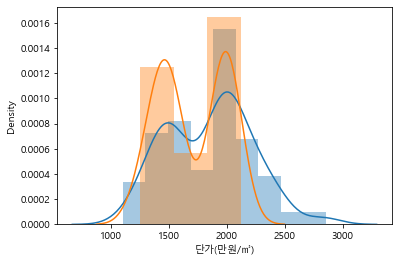

강동구
(163, 21)
count     163.000000
mean     1072.553665
std       191.624217
min       603.174603
25%       970.000000
50%      1043.636229
75%      1104.579683
max      2089.235127
Name: 단가(만원/㎡), dtype: float64
(92, 15)
count      92.000000
mean     1026.178539
std        66.629344
min       850.165468
25%       999.839286
50%      1043.000142
75%      1074.129305
max      1111.501112
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


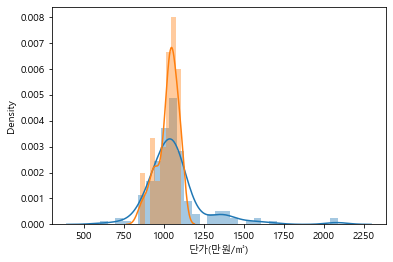

강북구
(39, 21)
count      39.000000
mean      783.345543
std       111.728047
min       589.915966
25%       737.478592
50%       784.117451
75%       809.574094
max      1019.714480
Name: 단가(만원/㎡), dtype: float64
(7, 15)
count      7.000000
mean     742.814537
std       13.428143
min      716.902699
25%      737.478592
50%      750.170086
75%      751.960468
max      753.750850
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


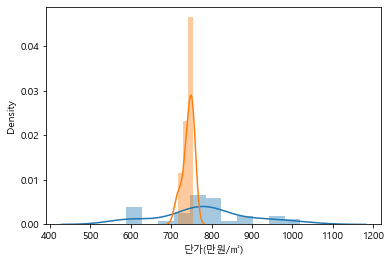

c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


강서구
(467, 21)
count     467.000000
mean      945.734253
std       102.336553
min       577.039275
25%       883.471776
50%       933.955971
75%       990.063875
max      1335.113485
Name: 단가(만원/㎡), dtype: float64
(20, 15)
count     20.000000
mean     944.216526
std       33.478673
min      896.425717
25%      909.693705
50%      966.433192
75%      966.995221
max      978.195938
Name: 단가(만원/㎡), dtype: float64


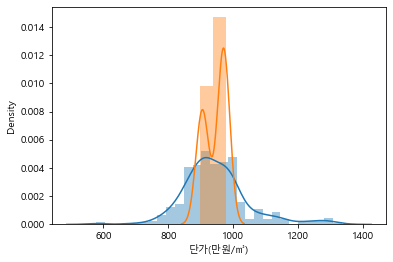

관악구
(108, 21)
count     108.000000
mean     1048.748380
std       181.621573
min       721.729334
25%       915.529906
50%      1044.328476
75%      1185.461957
max      1567.711808
Name: 단가(만원/㎡), dtype: float64
(15, 15)
count     15.000000
mean     782.853726
std       22.355176
min      721.729334
25%      772.200772
50%      786.338482
75%      798.137679
max      811.183139
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


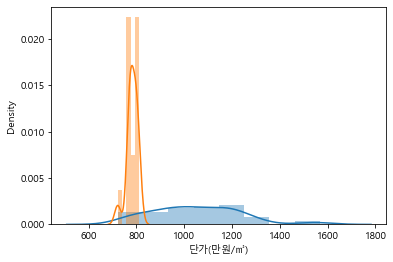

광진구
(149, 21)
count     149.000000
mean     1154.021863
std       301.637669
min       610.181311
25%       979.583824
50%      1053.001053
75%      1218.697830
max      2099.370189
Name: 단가(만원/㎡), dtype: float64
(66, 15)
count      66.000000
mean      977.251060
std        59.844437
min       845.797721
25%       975.233690
50%       981.285351
75%      1002.876173
max      1116.685830
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


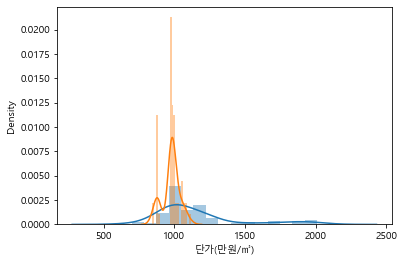

구로구
(115, 21)
count     115.000000
mean      871.459666
std       132.648033
min       457.429048
25%       786.098668
50%       847.287341
75%       963.210702
max      1342.113515
Name: 단가(만원/㎡), dtype: float64
(34, 15)
count     34.000000
mean     740.985460
std       47.628935
min      650.297119
25%      715.490416
50%      743.518519
75%      787.051842
max      813.144908
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


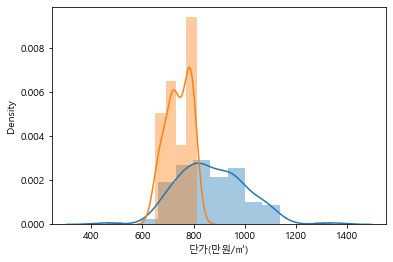

금천구
(479, 21)
count     479.000000
mean      877.317070
std        87.746930
min       642.394476
25%       842.465365
50%       903.290799
75%       922.052347
max      1224.347826
Name: 단가(만원/㎡), dtype: float64
(325, 15)
count    325.000000
mean     883.316676
std       69.596699
min      642.394476
25%      889.337974
50%      911.710072
75%      922.831254
max      960.381897
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


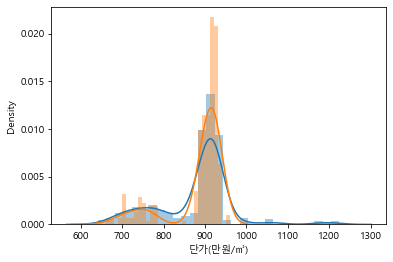

노원구
(31, 21)
count     31.000000
mean     762.701956
std       59.614279
min      642.785403
25%      751.827527
50%      767.341928
75%      799.816942
max      888.963435
Name: 단가(만원/㎡), dtype: float64
(21, 15)
count     21.000000
mean     766.006823
std       45.159835
min      651.748458
25%      755.640698
50%      766.470972
75%      792.049615
max      829.945799
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


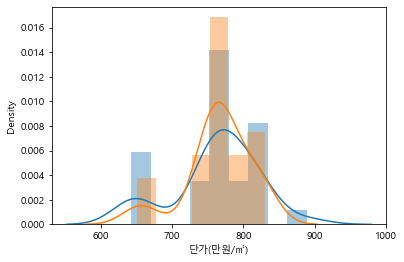

도봉구
(48, 21)
count     48.000000
mean     743.559992
std       87.489707
min      587.051325
25%      700.964288
50%      737.125547
75%      796.019900
max      940.627085
Name: 단가(만원/㎡), dtype: float64
(10, 15)
count     10.000000
mean     749.130214
std       53.580658
min      653.021442
25%      730.921701
50%      769.287806
75%      771.141512
max      826.277481
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


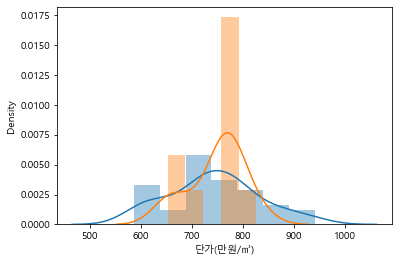

동대문구
(34, 21)
count      34.000000
mean     1088.319255
std       249.816510
min       826.989619
25%       875.879321
50%       997.787150
75%      1208.689704
max      1769.309289
Name: 단가(만원/㎡), dtype: float64
(5, 15)
count       5.000000
mean      938.414879
std        83.901770
min       871.388798
25%       871.388798
50%       889.350889
75%      1029.972954
max      1029.972954
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


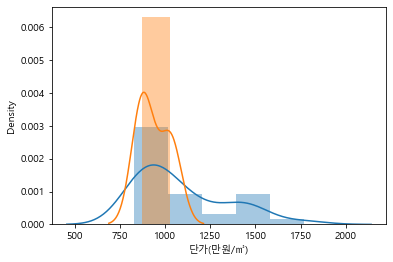

동작구
(113, 21)
count     113.000000
mean     1062.248190
std       117.798640
min       780.454700
25%       970.260650
50%      1067.391390
75%      1134.846462
max      1317.567568
Name: 단가(만원/㎡), dtype: float64
(59, 15)
count      59.000000
mean     1090.131214
std        84.315025
min       910.904000
25%      1018.038573
50%      1099.290780
75%      1134.846462
max      1256.946776
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


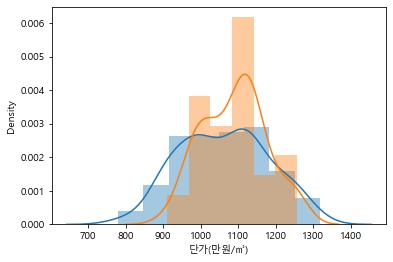

c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


마포구
(137, 21)
count     137.000000
mean     1392.696869
std       245.022338
min       833.622786
25%      1236.643503
50%      1387.478849
75%      1529.735304
max      2607.823470
Name: 단가(만원/㎡), dtype: float64
(38, 15)
count      38.000000
mean     1435.483167
std       137.488657
min      1220.182046
25%      1243.722536
50%      1529.735304
75%      1531.724553
max      1546.759886
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


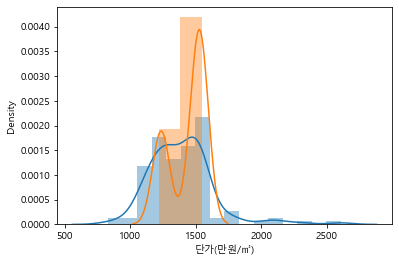

서대문구
(39, 21)
count      39.000000
mean      799.971056
std       113.540525
min       668.002672
25%       735.142932
50%       750.155900
75%       864.568232
max      1154.102735
Name: 단가(만원/㎡), dtype: float64
(12, 15)
count     12.000000
mean     750.545278
std        8.421924
min      735.482924
25%      749.250749
50%      750.077950
75%      751.268937
max      772.578088
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


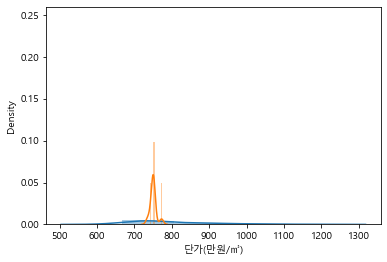

서초구
(190, 21)
count     190.000000
mean     1488.606087
std       205.961323
min      1273.186870
25%      1360.166037
50%      1453.651345
75%      1518.125274
max      2986.611740
Name: 단가(만원/㎡), dtype: float64
(159, 15)
count     159.000000
mean     1442.128390
std       108.402721
min      1273.186870
25%      1359.866631
50%      1426.503638
75%      1498.421116
max      1760.563380
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


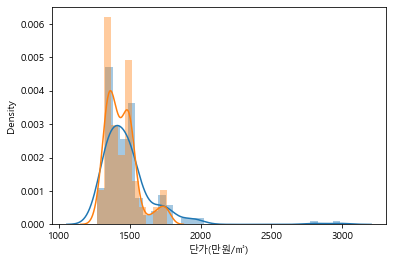

성동구
(7, 21)
count       7.000000
mean     1197.074906
std       290.170833
min       993.197279
25%      1093.605725
50%      1114.206128
75%      1118.706002
max      1847.497481
Name: 단가(만원/㎡), dtype: float64
(5, 15)
count       5.000000
mean     1107.765916
std        13.215359
min      1090.720222
25%      1096.491228
50%      1114.206128
75%      1118.530885
max      1118.881119
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


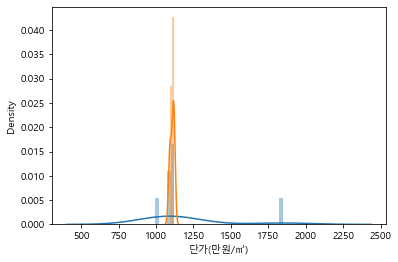

c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


성북구
(143, 21)
count     143.000000
mean      953.559539
std       181.522774
min       626.304802
25%       844.422868
50%       911.640954
75%       977.801605
max      2003.338898
Name: 단가(만원/㎡), dtype: float64
(24, 15)
count     24.000000
mean     865.979114
std       44.351131
min      826.986260
25%      833.430697
50%      845.484253
75%      881.728264
max      959.899192
Name: 단가(만원/㎡), dtype: float64


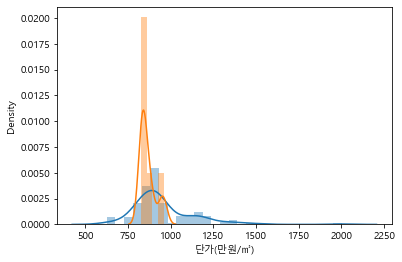

c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


송파구
(204, 21)
count     204.000000
mean     1223.347482
std       175.556058
min       693.069307
25%      1109.593718
50%      1266.367377
75%      1338.895281
max      1783.166904
Name: 단가(만원/㎡), dtype: float64
(167, 15)
count     167.000000
mean     1241.714685
std       152.742999
min       905.417815
25%      1167.055685
50%      1273.849607
75%      1337.501170
max      1783.166904
Name: 단가(만원/㎡), dtype: float64


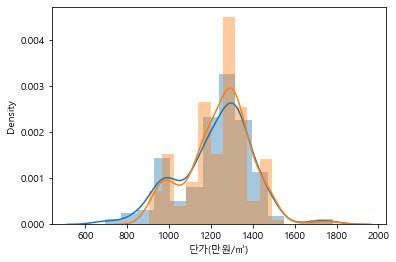

양천구
(188, 21)
count     188.000000
mean      925.926967
std       142.056953
min       669.872896
25%       819.009100
50%       877.968958
75%       995.687257
max      1290.969900
Name: 단가(만원/㎡), dtype: float64
(9, 15)
count       9.000000
mean      917.663846
std        74.269641
min       824.972129
25%       859.810955
50%       881.946658
75%       994.249675
max      1010.944166
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


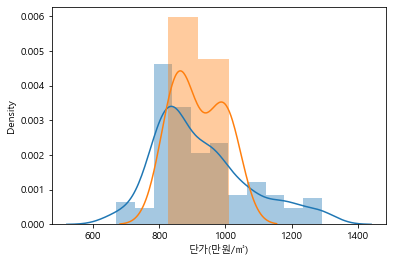

영등포구
(87, 21)
count      87.000000
mean     1150.934776
std       140.125814
min       786.216126
25%      1054.963864
50%      1202.321725
75%      1243.027999
max      1428.094761
Name: 단가(만원/㎡), dtype: float64
(37, 15)
count      37.000000
mean     1229.322641
std        33.019814
min      1180.321736
25%      1204.310973
50%      1221.591962
75%      1254.779671
max      1295.365717
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


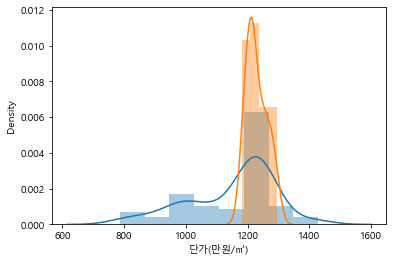

c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


용산구
(48, 21)
count      48.000000
mean     1635.467974
std       266.444687
min       991.796665
25%      1493.074321
50%      1598.147692
75%      1838.752043
max      2228.412256
Name: 단가(만원/㎡), dtype: float64
(0, 15)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2595: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\max6296\ml\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\max6296\ml\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


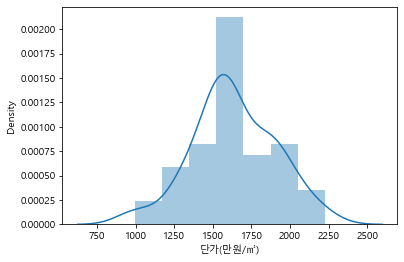

은평구
(160, 21)
count     160.000000
mean      911.819184
std       121.116160
min       684.702739
25%       814.536773
50%       897.934409
75%       991.292699
max      1246.969172
Name: 단가(만원/㎡), dtype: float64
(38, 15)
count      38.000000
mean      859.642243
std       113.802404
min       751.476114
25%       774.728244
50%       823.530473
75%       893.032925
max      1120.056003
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


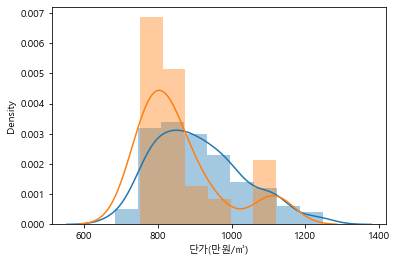

c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


종로구
(14, 21)
count      14.000000
mean     1191.753194
std        77.140105
min      1028.950122
25%      1145.123117
50%      1227.864450
75%      1250.422440
max      1270.478101
Name: 단가(만원/㎡), dtype: float64
(0, 15)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2595: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\max6296\ml\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\max6296\ml\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


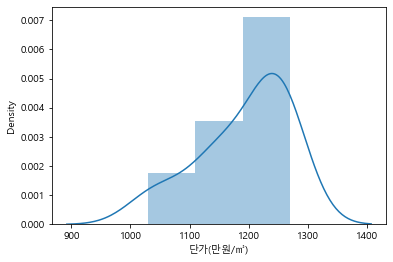

c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


중구
(10, 21)
count      10.000000
mean     1273.048799
std       114.415438
min      1137.884873
25%      1201.517301
50%      1284.618523
75%      1298.211408
max      1536.071798
Name: 단가(만원/㎡), dtype: float64
(0, 15)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2595: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\max6296\ml\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\max6296\ml\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


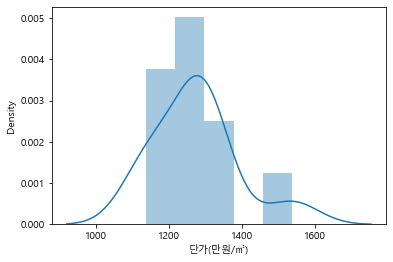

중랑구
(180, 21)
count     180.000000
mean      998.526563
std       132.909490
min       696.428571
25%       908.307885
50%       989.141752
75%      1034.629413
max      1325.850579
Name: 단가(만원/㎡), dtype: float64
(110, 15)
count     110.000000
mean     1026.452443
std       115.454118
min       871.131914
25%       936.590149
50%       996.721067
75%      1049.164808
max      1301.619133
Name: 단가(만원/㎡), dtype: float64


c:\users\max6296\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


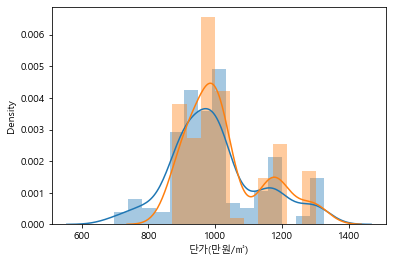

<Figure size 432x288 with 0 Axes>

In [113]:
for gu in target_df['구'].unique():
    gu_df = target_df[target_df['구'] == gu]
    bulktrade_gu_df = bulktrade_target_df[bulktrade_target_df['구'] == gu]
    
    print(gu)
    print(gu_df.shape)
    
    print(gu_df['단가(만원/㎡)'].describe())
    
    print(bulktrade_gu_df.shape)
    print(bulktrade_gu_df['단가(만원/㎡)'].describe())
    
    sns.distplot(gu_df['단가(만원/㎡)'])
    sns.distplot(bulktrade_gu_df['단가(만원/㎡)'])
    plt.show()
    plt.clf()
    
    target_df.loc[gu_df.index, '구별_25분위'] = gu_df['단가(만원/㎡)'].quantile(0.25)
    target_df.loc[gu_df.index, '구별_50분위'] = gu_df['단가(만원/㎡)'].quantile(0.5)
    target_df.loc[gu_df.index, '구별_75분위'] = gu_df['단가(만원/㎡)'].quantile(0.75)
    target_df.loc[gu_df.index, '구별_30분위'] = gu_df['단가(만원/㎡)'].quantile(0.30)
    target_df.loc[gu_df.index, '구별_35분위'] = gu_df['단가(만원/㎡)'].quantile(0.35)
    target_df.loc[gu_df.index, '구별_40분위'] = gu_df['단가(만원/㎡)'].quantile(0.40)

In [114]:
print(target_df['구별_25분위'].isna().sum())
print(target_df['구별_50분위'].isna().sum())
print(target_df['구별_75분위'].isna().sum())
print(target_df['구별_30분위'].isna().sum())
print(target_df['구별_35분위'].isna().sum())
print(target_df['구별_40분위'].isna().sum())

0
0
0
0
0
0


In [115]:
summary_df = target_df[['구', '구별_25분위', '구별_30분위', '구별_35분위', '구별_40분위', '구별_50분위', '구별_75분위'
                       ]].drop_duplicates().reset_index(drop=True)
print(summary_df.shape)
summary_df.head()

(25, 7)


,구,구별_25분위,구별_30분위,구별_35분위,구별_40분위,구별_50분위,구별_75분위
0,강남구,1552.737611,1561.527504,1596.263081,1777.003484,1919.632863,2055.505936
1,강동구,970.000000,1000.044863,1009.949444,1029.994341,1043.636229,1104.579683
2,강북구,737.478592,750.170086,753.750850,767.959973,784.117451,809.574094
3,강서구,883.471776,900.300100,904.279250,913.367154,933.955971,990.063875
4,관악구,915.529906,940.749577,968.603874,979.410007,1044.328476,1185.461957


In [116]:
summary_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/구별_분위별/최근12개월_연립다세대_건물연식_2년이하_전용면적크기_30제곱미터근처_실거래사례_구별_분위값들.xlsx', index=False)

In [ ]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [ ]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [ ]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [ ]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

In [ ]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
target_df1.head()

In [ ]:
target_df1_30 = target_df1[
    (target_df1['전용면적(㎡)'] >= 28)
    &(target_df1['전용면적(㎡)'] <= 32)
]

In [ ]:
target_df1_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [ ]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

In [ ]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [ ]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

In [ ]:
target_df2 = get_index_applied_prices(target_df2)

In [ ]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [ ]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [ ]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
concat_df = pd.concat([target_df2])

In [ ]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [ ]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [ ]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

In [ ]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

In [ ]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [ ]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [ ]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

In [ ]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)